In [20]:
## Library Imports
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as imbl
from hyperopt import hp, tpe, fmin
from plot_functions import *

from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

## Custom libraries
import index_helpers as ih
import data_transformations as dtrans

In [21]:
## Import, index, and split
df = ih.read_and_merge_segmented_data()
df = ih.index_df_by_person(df)
df = ih.categorical_float_to_int(df)
df = ih.categorical_to_dummy(df)
X_train, X_test, y_train, y_test = ih.train_test_split_on_index(features = df.drop("Label", axis=1),
                                                                label = df["Label"])

## Train naive regression model
#logit_naive = LogisticRegression(max_iter = 1000).fit(X_train, y_train)
#logit_naive.score(X_test, y_test)

(7009, 342)

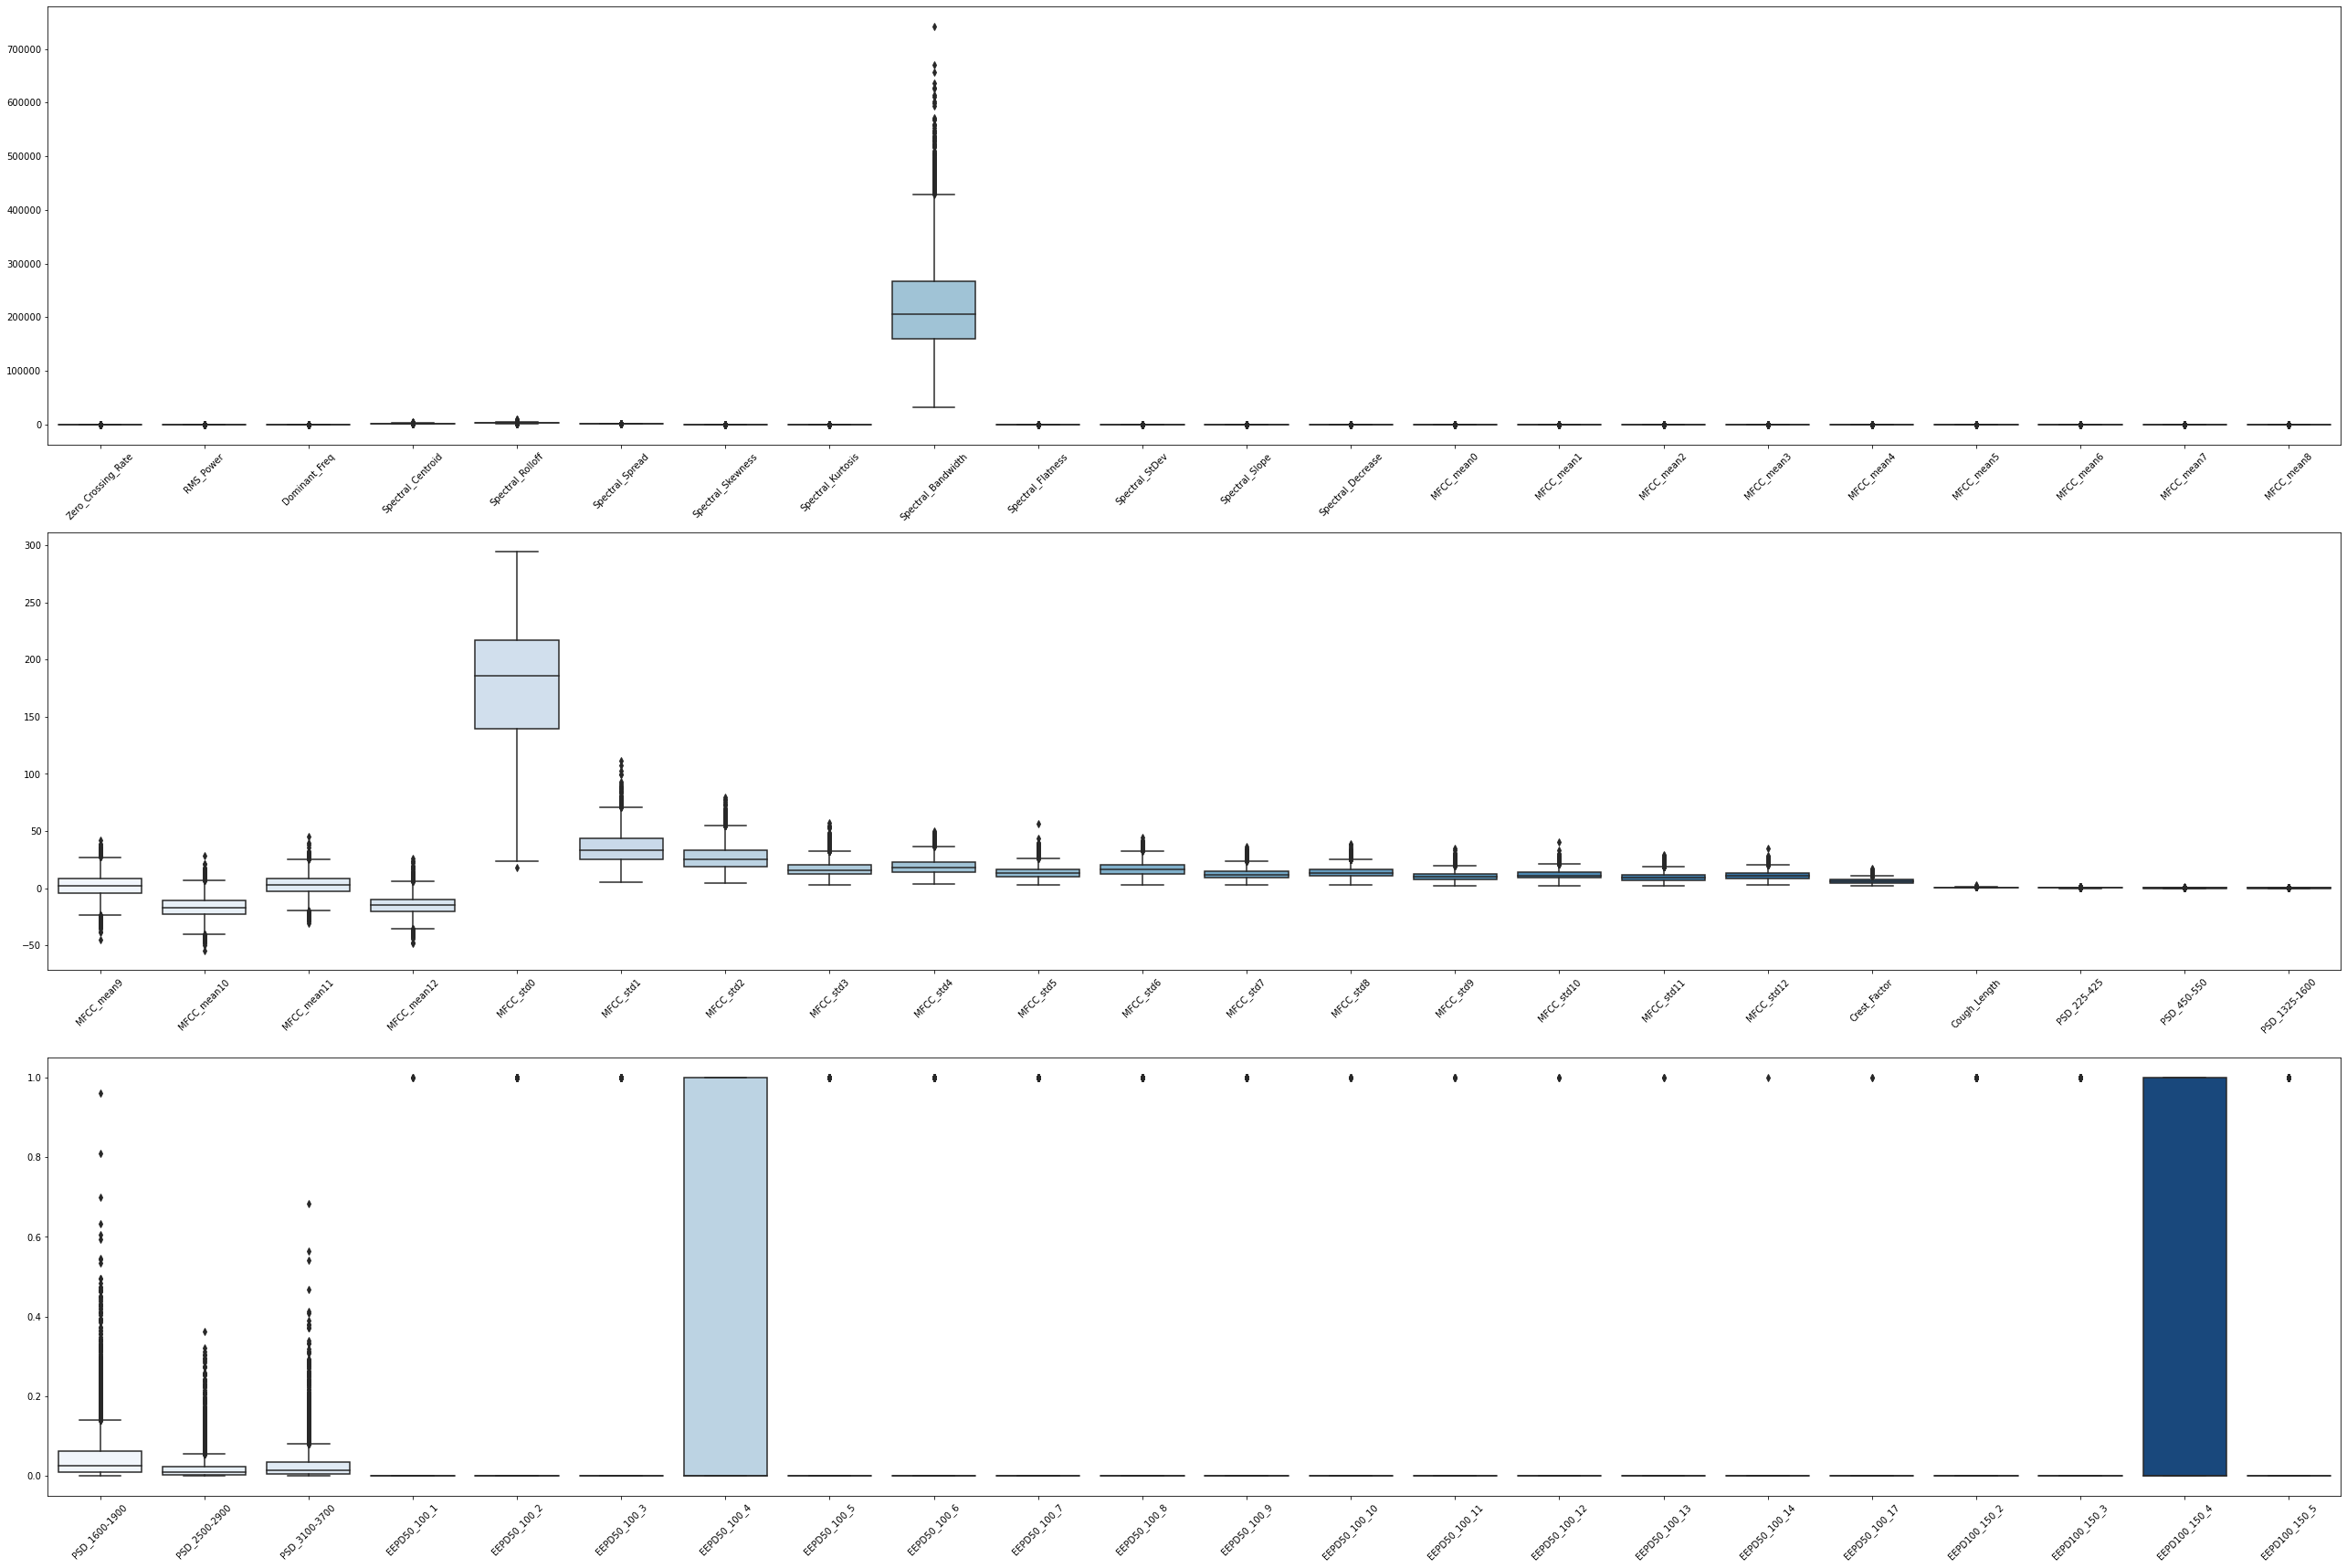

In [23]:
boxplot_features(df)
df.shape

### XGB without hyperparameter-tuning

In [24]:
## Create DMatrix - has to be done because of cv
dm_matrix = xgb.DMatrix(data=X_train, label=y_train)

## Create parameter dictionary.2
params = {'objective':'binary:logistic', 'max_depth':50}

## Perform CV
cv_results = xgb.cv(dtrain=dm_matrix, params=params, nfold=10, num_boost_round=200)

## Print AUC testing error
print("Train AUC: ", (cv_results["train-auc-mean"]).iloc[-1])
## Print AUC
print("Test AUC: ", (cv_results["test-auc-mean"]).iloc[-1])

Train AUC:  1.0
Test AUC:  0.7054271


In [14]:
X_train.head()

Zero_Crossing_Rate  \
File_Name_split                      File_n_recording                       
008ba489-31ad-44d8-856b-fcf72369dc46 0                           0.160222   
                                     1                           0.157047   
                                     2                           0.154893   
                                     3                           0.150417   
                                     4                           0.151335   

                                                       RMS_Power  \
File_Name_split                      File_n_recording              
008ba489-31ad-44d8-856b-fcf72369dc46 0                  0.128937   
                                     1                  0.092217   
                                     2                  0.075413   
                                     3                  0.049969   
                                     4                  0.049786   

                                                       Dominant_Freq  \
File_Name_split                      File_n_recording                  
008ba489-31ad-44d8-856b-fcf72369dc46 0                      0.031250   
                                     1                      0.062500   
                                     2                      0.046875   
                                     3                      0.046875   
                                     4                      0.050781   

                                                       Spectral_Centroid  \
File_Name_split                      File_n_recording                      
008ba489-31ad-44d8-856b-fcf72369dc46 0                       1773.765792   
                                     1                       1801.097694   
                                     2                       1589.223922   
                                     3                       1476.036555   
                                     4                       1478.032136   

                                                       Spectral_Rolloff  \
File_Name_split                      File_n_recording                     
008ba489-31ad-44d8-856b-fcf72369dc46 0                           3415.0   
                                     1                           2501.0   
                                     2                           2522.0   
                                     3                           2273.0   
                                     4                           2298.0   

                                                       Spectral_Spread  \
File_Name_split                      File_n_recording                    
008ba489-31ad-44d8-856b-fcf72369dc46 0                     1422.780346   
                                     1                     1486.201986   
                                     2                     1294.383203   
                                     3                     1301.461039   
                                     4                     1299.889388   

                                                       Spectral_Skewness  \
File_Name_split                      File_n_recording                      
008ba489-31ad-44d8-856b-fcf72369dc46 0                          0.758778   
                                     1                          0.657349   
                                     2                          1.037579   
                                     3                          1.146937   
                                     4                          1.138023   

                                                       Spectral_Kurtosis  \
File_Name_split                      File_n_recording                      
008ba489-31ad-44d8-856b-fcf72369dc46 0                          2.332231   
                                     1                          2.000908   
                                     2                          3.070197   
                                     3    

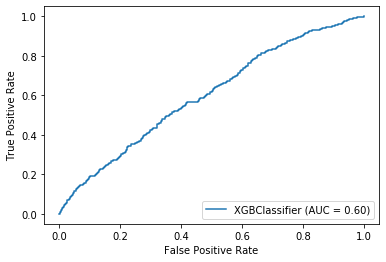

In [30]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              max_depth=50, 
                              n_estimators=200, 
                              seed=42)

xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)

#fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test, preds)
#auc_score_xgb = metrics.auc(fpr_xgb, tpr_xgb)

plot_roc_curve(xgb_model, X_test, y_test)

Definitively suffered from data leakage.... Does not perform nearly as well on the holdout set

### XGB CV with GroupKFold

In [82]:
from sklearn.model_selection import GroupKFold

## Split into training and testing data - passing X, y along with group to be split on
#fv = gkf.split(df_reset.drop('Label', axis=1), 
#               df_reset[['File_Name_split', 'Label']], 
#               groups=df_reset["File_Name_split"])
## I dunno how to use...

## Build classifier
clf = xgb.XGBClassifier(objective='binary:logistic', 
                        random_state=42)

#clf_param_grid = {'max_depth':np.arange(20, 50, 1), 
#                  'n_estimators': np.arange(25, 300, 25),
#                  'learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3))}

clf_param_grid = {'min_child_weight': [0.1, 1, 5, 10, 50],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [5, 10, 25, 50, 75],
                  'learning_rate': [0.0001, 0.001, 0.1, 1],
                  'n_estimators': [50, 100, 250, 500],
                  'reg_alpha': [0.0001, 0.001, 0.1, 1],
                  'reg_lambda': [0.0001, 0.001, 0.1, 1]}

## Instantiate GroupKFold - to be passed to cv
gkf=GroupKFold(n_splits=10)

## Set up Randomized search CV
rand_auc = RandomizedSearchCV(estimator=clf,
                              param_distributions=clf_param_grid,
                              cv=gkf, scoring='roc_auc', verbose=1, n_jobs=-1, n_iter=50)

## Reset index to give GroupKFold an
df_reset = df.reset_index()

## Perform search, pass X, y with group column, and set which column to be grouped by
X = df_reset.drop(columns=['File_Name_split', 'File_n_recording','Label'])
y = df_reset['Label']
groups = df_reset['File_Name_split']
                
rand_auc.fit(X, y, groups=groups)

## Print results
print("Best score: ",  rand_auc.best_score_)
print("Best estimator: ", rand_auc.best_estimator_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 620.9min


KeyboardInterrupt: 

### Bayesian Optimization

In [72]:
hp.loguniform('learning_rate', np.log(0.01), np.log(1))

In [89]:
## Modify data for GroupKFold
df_reset = df.reset_index()
X = X_train.reset_index(drop=True)
y = y_train.reset_index(drop=True)
groups = y_train.reset_index()['File_Name_split']

In [91]:
#from hyperopt.pyll.base import scope

## Stored hyperparameters to try later
# 'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1))

#param_hyperopt= {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
#                 'max_depth': scope.int(hp.quniform('max_depth', 20, 60, 2)),
#                 'n_estimators': scope.int(hp.quniform('n_estimators', 20, 200, 10)),
#                 'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
#                 'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
#                 'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)}

param_hyperopt= {'learning_rate': hp.quniform('learning_rate', 'learning_rate': [0.0001, 0.001, 0.1, 1], np.log(1)),
                 'max_depth': hp.quniform('max_depth', 20, 50, 10),
                 'n_estimators': hp.quniform('n_estimators', 100, 200, 10)}

def objective(params):
    params = {'learning_rate': float(params['learning_rate']),
              'max_depth': int(params['max_depth']),
              'n_estimators': int(params['n_estimators'])}
    xgb_clf = xgb.XGBClassifier(**params)
    
    gkf=GroupKFold(n_splits=5)
    best_score = cross_val_score(xgb_clf, X, y, cv=gkf, groups=groups, 
                                 scoring='roc_auc', n_jobs=2).mean()
    
    return -best_score
    
best_result = fmin(fn=objective, space=param_hyperopt, max_evals=500, algo=tpe.suggest, rstate=np.random.RandomState(42))

  1%|▏         | 7/500 [17:01<19:58:55, 145.91s/trial, best loss: -0.5642979418676494]


KeyboardInterrupt: 